In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics, utils
import pandas as pd
import seaborn as sns
import cv2
from PIL import Image
import os

In [2]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Number of different Classes:  43


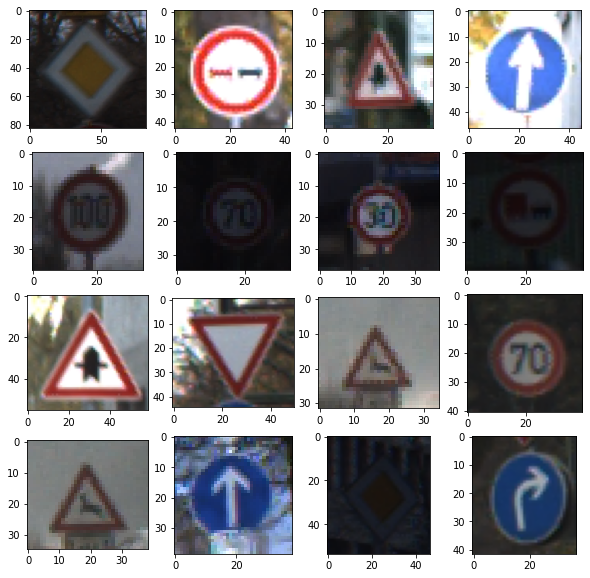

In [3]:
class_type = train_data['ClassId'].nunique()
print("Number of different Classes: ", class_type)

img_src = train_data["Path"]
num_rows = train_data['ClassId'].count()

sample = plt.subplots(4,4, figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    ind = np.random.randint(num_rows)
    plt.imshow(plt.imread(img_src[ind]))
#     plt.imshow(plt.imread(train_data["Path"][np.random.randint(num_rows)]))

plt.show()

In [4]:
train_data['ClassId']=train_data['ClassId'].astype('str')
train_data = pd.concat([train_data['Path'], train_data['ClassId']], axis = 1)
train_data = utils.shuffle(train_data)
train_data.head()

,Path,ClassId
10082,Train/5/00005_00055_00002.png,5
28502,Train/25/00025_00001_00002.png,25
11181,Train/7/00007_00015_00021.png,7
33076,Train/32/00032_00007_00016.png,32
26420,Train/18/00018_00028_00020.png,18


Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.
(200, 40, 40, 3)


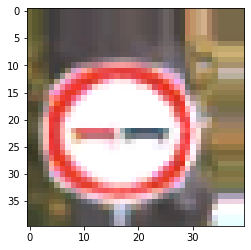

In [6]:
BATCH_SIZE = 200
IMG_SIZE = (40, 40)

imageValidation_Gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.2,
    fill_mode = 'nearest'
)

trainData_gen = imageValidation_Gen.flow_from_dataframe(
    train_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="training",
)

val_gen = imageValidation_Gen.flow_from_dataframe(
    train_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="validation",
)

gen = next(trainData_gen)
print(gen[0].shape)
plt.imshow(gen[0][0,:,:,:])

In [7]:
classifier = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(40,40, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
#using softmax as activation function instead of relu as it is a multiclass classification problem
    tf.keras.layers.Dense(class_type, activation='softmax') 
])

tf.keras.utils.plot_model (classifier, to_file = 'trained_classifier.png', 
                           show_shapes = True)

classifier.compile(
    loss = 'categorical_crossentropy', 
    optimizer = 'adam',
    metrics = ['accuracy']
)

print(classifier.summary())


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 16)        1168      
_________________________________________________________________
average_pooling2d (AveragePo (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D) 

In [8]:
history = classifier.fit(x = trainData_gen,
                         epochs = 15,
                         validation_data = val_gen,
                         verbose = True
                        )

Epoch 1/15
157/157 [==============================] - 1025s 7s/step - loss: 1.2318 - accuracy: 0.6531 - val_loss: 4.3960 - val_accuracy: 0.0568
Epoch 2/15
157/157 [==============================] - 97s 618ms/step - loss: 0.2360 - accuracy: 0.9271 - val_loss: 3.5647 - val_accuracy: 0.1432
Epoch 3/15
157/157 [==============================] - 101s 645ms/step - loss: 0.1214 - accuracy: 0.9618 - val_loss: 1.1544 - val_accuracy: 0.6462
Epoch 4/15
157/157 [==============================] - 98s 625ms/step - loss: 0.0804 - accuracy: 0.9753 - val_loss: 0.1334 - val_accuracy: 0.9586
Epoch 5/15
157/157 [==============================] - 98s 625ms/step - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.1033 - val_accuracy: 0.9672
Epoch 6/15
157/157 [==============================] - 99s 628ms/step - loss: 0.0422 - accuracy: 0.9874 - val_loss: 0.0695 - val_accuracy: 0.9795
Epoch 7/15
157/157 [==============================] - 98s 626ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0615 - val_ac

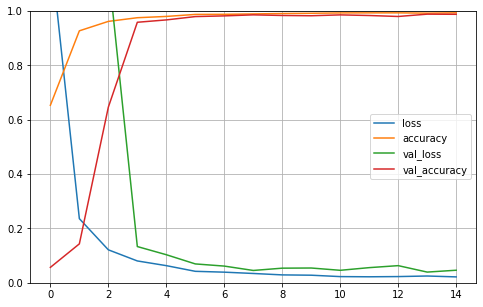

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [10]:
test_data['ClassId'] = test_data['ClassId'].astype('str')

test_gen = imageValidation_Gen.flow_from_dataframe(
    test_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
)

classifier.evaluate(test_gen)


Found 12630 validated image filenames belonging to 43 classes.
64/64 [==============================] - 236s 4s/step - loss: 0.2070 - accuracy: 0.9464


[0.2069520205259323, 0.9463974833488464]